In [ ]:
import sys
sys.path.append('/nfs/stak/users/sumons/HP-OSU-Capstone-2023-2024-dev/')

In [ ]:
import torch
import matplotlib.pyplot as plt
import os

from config.config import train_val_ratio, target
from dataloader.load_data import load_dataloader
from utils.save_load_model import save
from utils.metrics import binary_iou
from utils.convert import convertBinary

from config.args import get_arguments
from config.config import features,labels,duplex_labels,train_test_ratio,label_extension,threshold,random
from dataloader.load_data import SimplexDataset, DuplexDataset, InputSimplexDataset, InputDuplexDataset
from utils.load_json import load_results
from utils.save_load_model import load
from utils.convert import convertBinary


import logging
import os
import torch
import json
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split, DataLoader, Subset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models.segmentation as segmentation

In [ ]:
# label_folder = '/nfs/hpc/share/sumons/working_folder/Data/Output'
# input_folder = '/nfs/hpc/share/sumons/working_folder/Data/Input'

In [ ]:
label_folder = '/nfs/hpc/share/sumons/output'
input_folder = '/nfs/hpc/share/sumons/input'

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
pdf,algorithm,intermediate = load_results(label_folder)

In [ ]:
dataset = DuplexDataset(input_folder,label_folder,intermediate)

In [ ]:
train_dataloader, val_dataloader = load_dataloader(dataset,4,train_val_ratio)

In [ ]:
print(len(train_dataloader))
print(len(val_dataloader))

In [ ]:
class CustomDeepLabV3(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomDeepLabV3, self).__init__()
        # Initialize DeepLabV3 with a ResNet-50 backbone
        self.model = segmentation.deeplabv3_resnet101(pretrained=False, num_classes=num_classes)

        # Modify the first convolutional layer to accept 5-channel input
        self.model.backbone.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        # DeepLabV3 forward pass
        output = self.model(x)['out']
#         output = torch.squeeze(output, 1)
#         binary_output = torch.where(output < 0.5, torch.tensor(0.0, device=output.device), torch.tensor(1.0, device=output.device))
        return torch.sigmoid(output)

# Example of using the model
model = CustomDeepLabV3()
model= nn.DataParallel(model).to(device)

model_path = '/nfs/hpc/share/sumons/working_folder/saved_models/duplex.pth'
model.load_state_dict(torch.load(model_path))

# input_tensor = torch.randn(4, 10, 300, 300).to(device)  # Example input batch with 5 channels
# output = model(input_tensor)

# print(output.shape)

In [ ]:
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
for batch_data in train_dataloader:
    print(batch_data[0].shape)
    print(batch_data[0][0][0])
    print(batch_data[1].shape)
    break

In [ ]:
class IOU(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # intersection is equivalent to True Positive count
        # union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [ ]:
iou_fn = IOU()

In [ ]:
num_epochs = 5
loss_deeplab = []
val_loss = []
iou_deeplab = []
val_iou = []
for epoch in range(num_epochs):
    print('Training the model...')
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    running_iou = 0.0
    running_val_iou = 0.0
    
    for batch_data in train_dataloader:
        inputs, masks = batch_data[0].to(device), batch_data[1].to(device)
        inputs = inputs/255.0
        optimizer.zero_grad()
        
        outputs = model(inputs.float())
        loss = criterion(outputs, masks)
        iou = iou_fn(outputs, masks)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_iou += iou.item()
    print('Training epoch done...')
    epoch_loss = running_loss / len(train_dataloader)
    loss_deeplab.append(epoch_loss)
    
    with torch.no_grad():
        for batch_data in val_dataloader:
            inputs, masks = batch_data[0].to(device), batch_data[1].to(device)
            inputs = inputs/255.0
            outputs = model(inputs.float())
            loss = criterion(outputs, masks)
            iou = iou_fn(outputs, masks)
            
            running_val_loss += loss.item()
            running_val_iou += iou.item()
    print('Validation done...')    
    epoch_val_loss = running_val_loss / len(val_dataloader)
    val_loss.append(epoch_val_loss)  
    epoch_iou = running_iou / len(train_dataloader)
    val_iou = running_val_iou / len(val_dataloader)
    
    
    
    
    torch.save(model.state_dict(), '/nfs/hpc/share/sumons/working_folder/saved_models/duplex.pth')
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}, Val Loss: {epoch_val_loss:.4f}, Val IoU: {val_iou:.4f}")

    


In [ ]:
def eval_model():
    output_images = []
    masks_ = []
    model.eval()
    with torch.no_grad():
        for batch_data in val_dataloader:
            inputs, masks = batch_data[0].to(device), batch_data[1].to(device)
            inputs = inputs/255.0
            outputs = model(inputs.float())
            output_images.append(outputs)
            masks_.append(masks)
    return output_images, masks_

In [ ]:
output_images, masks_ = eval_model()

In [43]:
masks_[0][1].shape

torch.Size([8, 300, 300])

In [14]:
# fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# titles = ['HighMoistureSimplexPage_bitmap', 'HighMoistureSimplexObject1.3cm_bitmap', 'HighMoistureSimplexObject2.5cm_bitmap']

# index = 12
# batch_index = 3
# for i in range(3):
#     # Display each mask in the first row
#     axs[0, i].imshow(masks_[index][batch_index][i].cpu(), cmap='gray')
#     axs[0, i].axis('off')  # Hide axes for clarity
#     axs[0, i].set_title(titles[i])
    
    
    
#     axs[1, i].imshow((output_images[index][batch_index][i]*255.0).cpu(), cmap='gray')
#     axs[1, i].axis('off')  # Hide axes for clarity
# #     axs[1, i].set_title(titles[i])

# plt.tight_layout()  # Adjust subplots to fit into the figure area
# plt.show()  # Display the plot

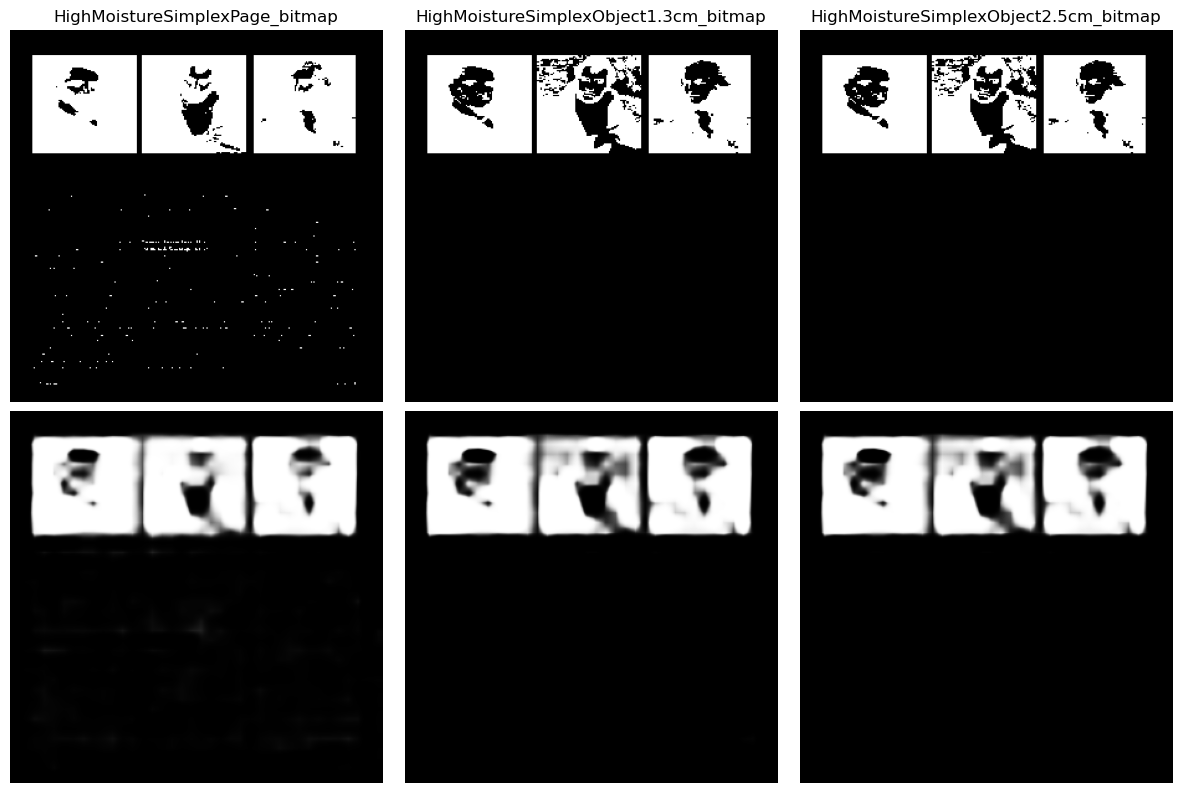

In [193]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

titles = ['HighMoistureSimplexPage_bitmap', 'HighMoistureSimplexObject1.3cm_bitmap', 'HighMoistureSimplexObject2.5cm_bitmap']

index = 12
batch_index = 3
for i in range(3):
    # Display each mask in the first row
    axs[0, i].imshow(masks_[index][batch_index][i].cpu(), cmap='gray')
    axs[0, i].axis('off')  # Hide axes for clarity
    axs[0, i].set_title(titles[i])
    
    
    
    axs[1, i].imshow((output_images[index][batch_index][i]*255.0).cpu(), cmap='gray')
    axs[1, i].axis('off')  # Hide axes for clarity
#     axs[1, i].set_title(titles[i])

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display the plot

In [198]:
# output_images[index][batch_index][i][0][0]*255

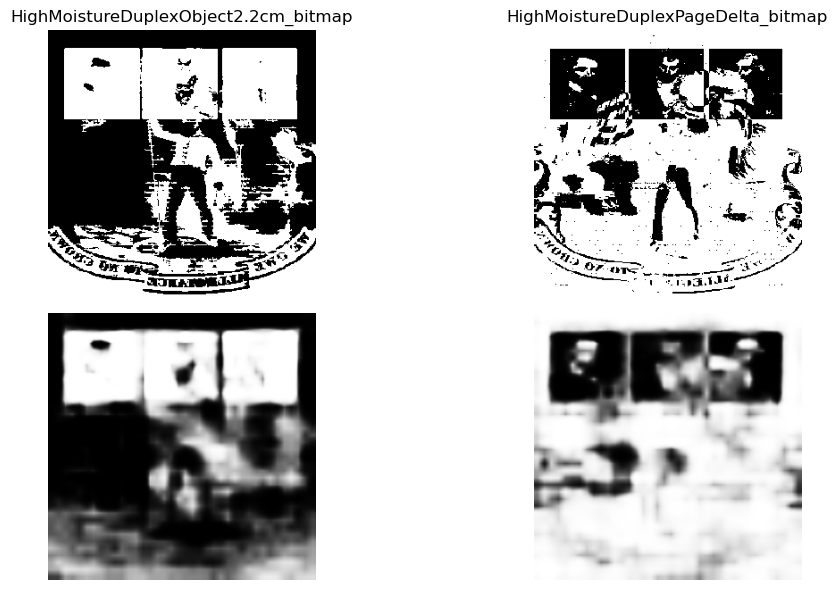

In [203]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

titles = ['HighMoistureDuplexObject2.2cm_bitmap','HighMoistureDuplexPageDelta_bitmap']

index = 12
batch_index = 3
for i in range(2):
#     print(i)
    # Display each mask in the first row
    axs[0, i].imshow(masks_[index][batch_index][i+3].cpu(), cmap='gray')
    axs[0, i].axis('off')  # Hide axes for clarity
    axs[0, i].set_title(titles[i])
    
    
    
    axs[1, i].imshow((output_images[index][batch_index][i+3]*255).cpu(), cmap='gray')
    axs[1, i].axis('off')  # Hide axes for clarity
#     axs[1, i].set_title(titles[i])

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display the plot

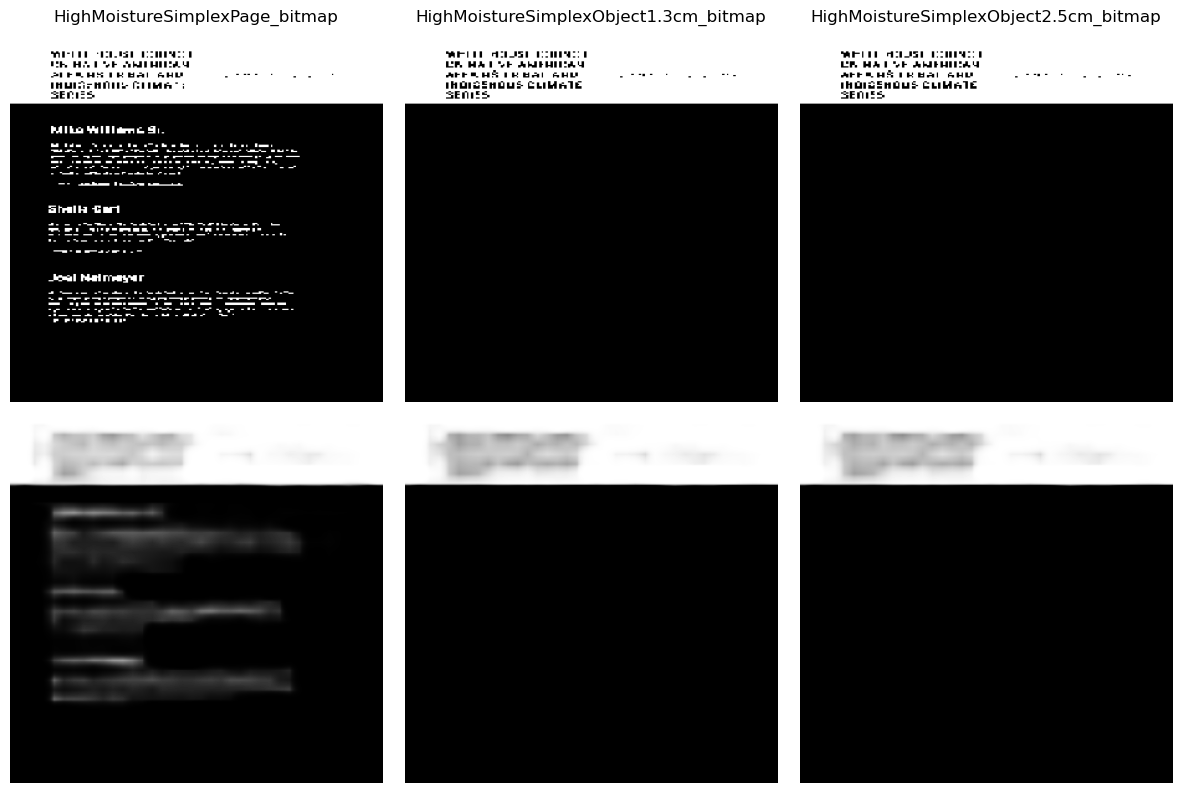

In [202]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

titles = ['HighMoistureSimplexPage_bitmap', 'HighMoistureSimplexObject1.3cm_bitmap', 'HighMoistureSimplexObject2.5cm_bitmap']

index = 14
batch_index = 3
for i in range(3):
    # Display each mask in the first row
    axs[0, i].imshow(masks_[index][batch_index][i+5].cpu(), cmap='gray')
    axs[0, i].axis('off')  # Hide axes for clarity
    axs[0, i].set_title(titles[i])
    
    
    
    axs[1, i].imshow((output_images[index][batch_index][i+5]*255).cpu(), cmap='gray')
    axs[1, i].axis('off')  # Hide axes for clarity
#     axs[1, i].set_title(titles[i])

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display the plot

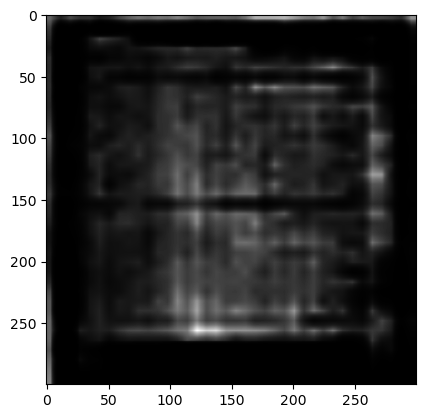

In [180]:
plt.imshow(output_images[10][1][4].cpu(), cmap='gray')

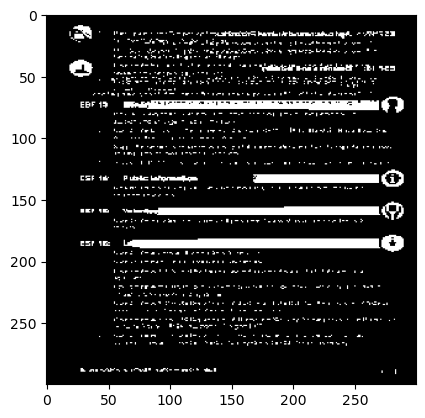

In [179]:
plt.imshow(masks_[10][3][4].cpu(), cmap='gray')